In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from cmap import Colormap
import os
from enum import Enum
from utils import *

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

from scipy.signal import butter, sosfilt, find_peaks
from scipy import interpolate

In [3]:
# class Labels(Enum):
#     SUBJECT_1 = 0
#     SUBJECT_2 = 1
#     SUBJECT_3 = 2
#     SUBJECT_4 = 3

In [4]:
# path = 'dataset/MXene_1 2min SM+L.txt'
# sample_rate = 1000

# timestamp, sig = load(path, fs=sample_rate)

# sos1 = butter(N=3, Wn=60, btype='lowpass', output='sos', fs=sample_rate)
# sos2 = butter(N=3, Wn=[59, 61], btype='bandstop', output='sos', fs=sample_rate)
# sos3 = butter(N=3, Wn=0.5, btype='highpass', output='sos', fs=sample_rate)

# sig_f1 = sosfilt(sos1, sig, axis=0)
# sig_f2 = sosfilt(sos2, sig_f1, axis=0)
# sig_f = sosfilt(sos3, sig_f2, axis=0)

# plt.plot(sig_f[:, :4])
# plt.xlim(0, 10000)
# plt.show()

In [5]:
class FeatureConstructor():

    def __init__(self, path, sample_rate, debug=False):
        timestamps, sig = load(path, fs=sample_rate)
        self.timestamps = timestamps
        self.sig = sig
        self.sample_rate = sample_rate
        print(f'Data loaded from {path}')

        # container for slices
        self.features = None

        # flag for preprocessing
        self.isProcessed = False

        # flag for debugging
        self.debug = debug

    def __len__(self):
        if self.features is None:
            raise IndexError('No slice has been contructed.')
        else:
            return self.features.shape[0]

    def preprocess_(self):
        '''butterworth filters.
        '''
        sos1 = butter(N=3, Wn=60, btype='lowpass', output='sos', fs=self.sample_rate)
        self.sig = sosfilt(sos1, self.sig, axis=0)
        self.sig1_ = self.sig  # temperarily keep the current sig
        sos2 = butter(N=3, Wn=[59, 61], btype='bandstop', output='sos', fs=self.sample_rate)
        self.sig = sosfilt(sos2, self.sig, axis=0)
        self.sig2_ = self.sig  # temperarily keep the current sig
        sos3 = butter(N=3, Wn=0.5, btype='highpass', output='sos', fs=self.sample_rate)
        self.sig = sosfilt(sos3, self.sig, axis=0)
        self.sig3_ = self.sig  # a copy of the final result

        self.isProcessed = True

    def preprocess(self):
        self.preprocess_()

    def get_features(self, ref, window_width_s):
        self.window_width_s = window_width_s
        self.window_width = window_width_s * self.sample_rate

        # get reference channel of left and right for find_peaks
        chnl_l = self.sig[:, ref[0] - 1]
        chnl_r = self.sig[:, ref[1] - 1]
        # find peaks
        peaks_l, _ = find_peaks(chnl_l, distance=0.8 * self.sample_rate)
        peaks_r, _ = find_peaks(chnl_r, distance=0.8 * self.sample_rate)
        
        # create a copy of the find_peaks output
        self.peaks_l_ = peaks_l
        self.peaks_r_ = peaks_r
        
        # check if peaks are alternative.
        valid_peaks_l, valid_peaks_r = self.validate_peaks_()

        # check if there are extra peaks at the end, trim the unnecessary peaks
        min_len = min(len(valid_peaks_l), len(valid_peaks_r))
        valid_peaks_l = np.array(valid_peaks_l[:min_len])
        valid_peaks_r = np.array(valid_peaks_r[:min_len])

        peak_diff = [peak_l - peak_r > 0 for peak_l, peak_r in zip(valid_peaks_l, valid_peaks_r)]
        if not all(peak_diff):
            if self.debug:
                print(peak_diff)
            raise ValueError(f'Not all left channel peaks are greater than right.')

        # at this point, there should be equal number of peaks of left and right channel
        # calculate the mean value of the two arrays, each pair of peaks should yield one
        # mean value, which becomes the central point of peak_expand
        peaks = ((valid_peaks_l + valid_peaks_r) / 2).astype(int)

        # create a copy of the peaks arrays
        self.valid_peaks_l = valid_peaks_l
        self.valid_peaks_r = valid_peaks_r
        self.peaks = peaks
        if self.debug:
            print(f'Found {len(peaks)} peak(s) in channels.')

        # peak expand, this will expand the peak indexes to left and right
        # to form a window that centered at the peak that we just found
        # also prevent any window that is over the maximum timestamp
        expanded_peaks = peak_expand(peaks, window_width=int(self.window_width), max=self.timestamps[-1] * self.sample_rate)

        # construct slices based on the peaks that we found in the previous step
        if not self.isProcessed:
            self.preprocess_()  # only start preprocessing after peak locating
            
        features = []
        for idx in range(expanded_peaks.shape[0]):
            features.append(self.sig[expanded_peaks[idx, :]])
        self.features = np.array(features)

    def validate_peaks_(self):
        '''check if peaks are alternative.
        if there are more than 1 peak in the interval of 2 peaks of another channel
        only keep the earliest one;
        this also keeps the left channel is earlier than the right channel on every
        index
        '''
        valid_peaks_l = []
        valid_peaks_r = []
        
        # sort all peaks while keeping track of their origin
        combined_peaks = \
            [(peak, 'L') for peak in self.peaks_l_] + \
            [(peak, 'R') for peak in self.peaks_r_]
        combined_peaks.sort(key=lambda x: x[0], reverse=True)
        
        # remove peaks from combined_peaks until the first one is 'L'
        while combined_peaks and combined_peaks[-1][1] != 'L':
            combined_peaks.pop()

        # Ensure alternating ('L', 'R', 'L', 'R', ...)
        expected_origin = 'L'  # a flag to imply the next expected label
        for peak, origin in combined_peaks:
            if origin == expected_origin:
                # Append peak to the correct list
                if origin == 'L':
                    valid_peaks_l.append(peak)
                    expected_origin = 'R'
                else:
                    valid_peaks_r.append(peak)
                    expected_origin = 'L'
            else:
                pass  # do nothing
        
        if self.debug:
            print(combined_peaks)
        
        return valid_peaks_l, valid_peaks_r


    def set_slice_outlier_filter_(self, num_std):
        self.mask = np.all(np.array([filter_windows(channel, num_std) for channel in np.transpose(self.features, (1, 0, 2))]), axis=0)
        return self.mask

    def use_slice_outlier_filter_(self):
        self.features = self.features[self.mask.astype(bool), :, :]

    def get_features_no_outliers(self, ref, window_width_s, num_std):
        self.get_features(ref, window_width_s)
        self.set_slice_outlier_filter_(num_std)
        self.use_slice_outlier_filter_()
        self.features = self.features.transpose(0, 2, 1)  # reshape to [num_samples, num_channels, seq_len]
        print(f'Found {self.features.shape[0]} slices that satisfy Gaussian distribution.\n')

    def get_labels(self, label: int):
        if self.features is None:
            raise IndexError('No labels can be generated because there are no features')
        self.labels = label * np.ones(self.features.shape[0])

    def get_mean_chnl(self):
        '''Get mean pattern for each channel
        '''
        return np.mean(self.features, axis=0)  # average over all samples

    def plot_features(self):
        # calculate the average of every channel to make it easier to see
        self.avg_feature = self.get_mean_chnl()
        self.fig, self.axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
        for feature in self.features:
            for ax, chnl in zip(self.axes.flat, feature):
                ax.plot(chnl, c='silver')
        
        for idx, ax in enumerate(self.axes.flat):
            ax.plot(self.avg_feature[idx, :], 'r')
            
            ax.set_ylim(-0.5, 0.5)
            ax.set_yticks([])
            
            ax.set_xlim(0, self.window_width)
            ax.set_xticks([0, self.window_width])

        plt.show()

In [6]:
# need to change every time
start_file = 1
end_file = 13
num_files = end_file - start_file + 1

df = pd.read_csv('best.csv', header=None)
files = df[0].tolist()[start_file - 1: end_file]
refs = df.iloc[:, 1:].to_numpy().tolist()[start_file - 1: end_file]

In [7]:
workers = []
all_features = []
all_labels = []

for n in range(num_files):
    path = files[n]
    ref = refs[n]

    worker = FeatureConstructor(os.path.join('dataset', path + '.txt'), sample_rate=1000)
    worker.preprocess()
    worker.get_features_no_outliers(ref, window_width_s=1.5, num_std=3)
    worker.get_labels(n)
    workers.append(worker)

    all_features.append(worker.features)
    all_labels.append(worker.labels)

Data loaded from dataset\OXene 2min F+L.txt
Found 71 slices that satisfy Gaussian distribution.

Data loaded from dataset\OXene 2min L+L.txt
Found 82 slices that satisfy Gaussian distribution.

Data loaded from dataset\OXene 2min L+N.txt
Found 84 slices that satisfy Gaussian distribution.

Data loaded from dataset\OXene 2min N+N.txt
Found 67 slices that satisfy Gaussian distribution.

Data loaded from dataset\OXene 2min S+F.txt
Found 79 slices that satisfy Gaussian distribution.

Data loaded from dataset\OXene 2min S+S.txt
Found 73 slices that satisfy Gaussian distribution.

Data loaded from dataset\OXene 2min SM+L.txt
Found 77 slices that satisfy Gaussian distribution.

Data loaded from dataset\OXene 2min SM+SM.txt
Found 68 slices that satisfy Gaussian distribution.

Data loaded from dataset\OXene 2min XS+XS.txt
Found 60 slices that satisfy Gaussian distribution.

Data loaded from dataset\OXene 2min F+F.txt
Found 54 slices that satisfy Gaussian distribution.

Data loaded from dataset\

(10000.0, 15000.0, -0.18279301261285358, 0.2878976215338172)

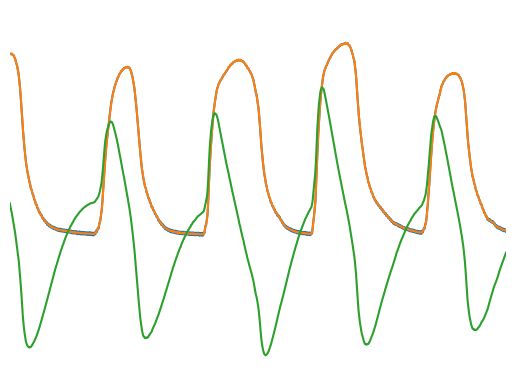

In [18]:
worker = workers[0]
plt.plot(worker.sig1_[:, 0])
plt.plot(worker.sig2_[:, 0])
plt.plot(worker.sig3_[:, 0])
plt.xlim(10000, 15000)
plt.axis('off')

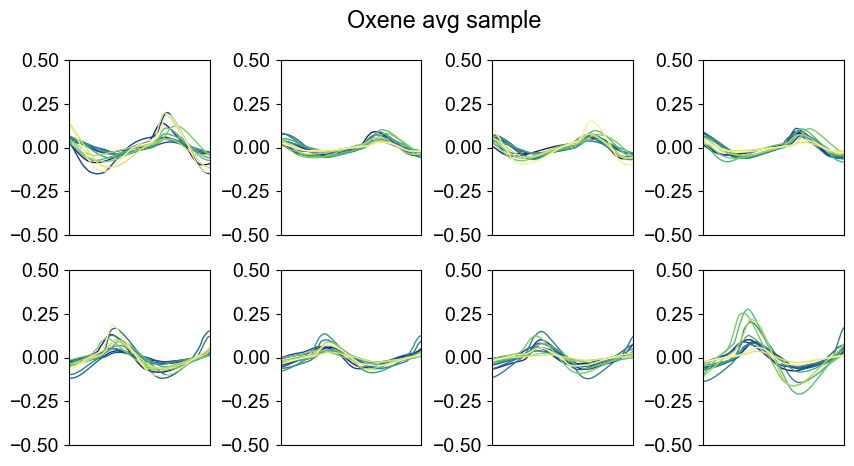

In [12]:
colors = Colormap('cmocean:haline')(np.linspace(0, 1, len(workers)))

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

for idx, ax in enumerate(axes.flat):
    for color, worker in zip(colors, workers):
        ax.plot(worker.get_mean_chnl()[idx, :], c=color, lw=1)
        ax.set_ylim(-0.5, 0.5)
        ax.set_xlim(0, 1500)
        ax.set_xticks([])

fig.suptitle('Oxene avg sample')
plt.show()

# window stack

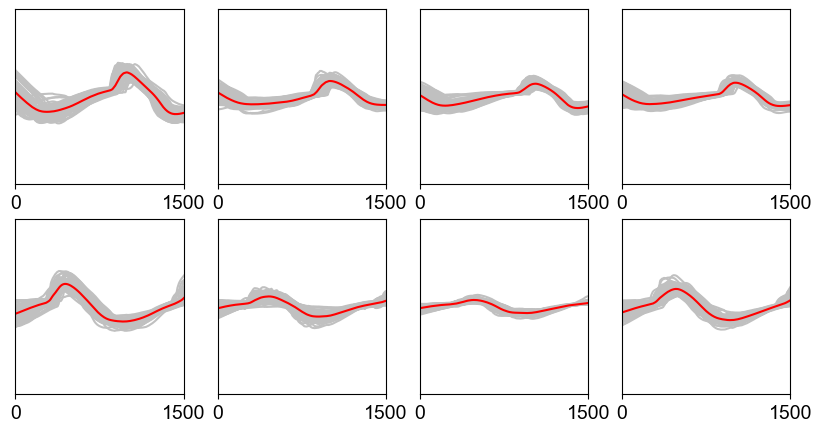

In [13]:
workers[0].plot_features()

In [16]:
import torch
from gait_dataset import GaitDataset

In [17]:
features = torch.cat([torch.tensor(feature) for feature in all_features])
labels = torch.cat([torch.tensor(label) for label in all_labels])

In [18]:
print(features.shape)
print(labels.shape)

torch.Size([924, 8, 1500])
torch.Size([924])


In [19]:
ds = GaitDataset(features, labels)

In [90]:
# torch.save(ds, 'dataset/gait_o.pt')